<a href="https://colab.research.google.com/github/rpitonak/building-segmentation/blob/master/submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Open Cities AI Challenge: Segmenting Buildings for Disaster Resilience

This is my solution to [Open Cities AI Challenge: Segmenting Buildings for Disaster Resilience](https://www.drivendata.org/competitions/60/building-segmentation-disaster-resilience/page/150/).

Sources:

1) How to prepare [patches of data for training](https://medium.com/@anthropoco/how-to-segment-buildings-on-drone-imagery-with-fast-ai-cloud-native-geodata-tools-ae249612c321).


2) [Getting started guide](https://colab.research.google.com/drive/1Fv-80b1m-O-0p1g59NDzD82XdgurWlwa) from [johnowhitaker](https://community.drivendata.org/u/johnowhitaker/summary).

3) [Fast.AI](https://docs.fast.ai/)

Google colab notebook was bootstraped using [colab-bootstrap](https://github.com/zaitra/colab-bootstrap) by [Zaitra](https://zaitra.io).


# Install python packages

In [0]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import sys
import os
import datetime
from enum import Enum
from pathlib import Path


#import solaris as sol
# Basics of Python data handling and visualization
import skimage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.transform import from_bounds
from rasterio.windows import Window
from rio_tiler import main as rt_main

from shapely.geometry import Polygon
from shapely.ops import cascaded_union

from pystac import Catalog, CatalogType, Item, Asset, LabelItem, Collection
from tqdm import tqdm

# Google drive

Mount google drive folder with data to machine provided by google collab.

In [0]:
import os

from google.colab import drive
from pathlib import Path

drive.mount('/content/gdrive')

GOOGLE_DRIVE_PATH = Path('/content/gdrive/My Drive')
WORKDIR = 'segmentation' # specify the path to folder which you are intend to work with in this notebook
WORKDIR_PATH = GOOGLE_DRIVE_PATH / WORKDIR

if not os.path.exists(WORKDIR_PATH):
          os.mkdir(WORKDIR_PATH)

Set the paths

In [0]:
IMG_PATH = WORKDIR_PATH /'images-256'
MASK_PATH = WORKDIR_PATH /'masks-256'
IMG_PATH.mkdir(exist_ok=True)
MASK_PATH.mkdir(exist_ok=True)

# Generate submission

In [0]:
import glob
from PIL import Image as PImage

Prepare list of the test images

In [0]:
test_ims = glob.glob(str(WORKDIR_PATH) + '/data/test/*/*.tif')
print("Found ", len(test_ims), "images")

Found  11481 images
(11481, 2)


,fn,id
0,/content/gdrive/My Drive/segmentation/data/tes...,e952c8
1,/content/gdrive/My Drive/segmentation/data/tes...,e97411
2,/content/gdrive/My Drive/segmentation/data/tes...,e94086
3,/content/gdrive/My Drive/segmentation/data/tes...,e91b9c
4,/content/gdrive/My Drive/segmentation/data/tes...,e949a1


Load Paths as pnadas DataFrame

In [0]:
test_df = pd.DataFrame({
    'fn':test_ims,
    'id':[t.split('/')[7] for t in test_ims]
})
print(test_df.shape)
test_df.head()

Show sample image from test dataset

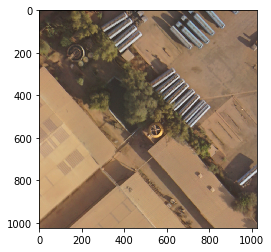

In [0]:
idx = random.choice(range(len(test_df)))
im = PImage.open(test_df.fn.values[idx])
plt.imshow(np.array(im))

Load the exported model

In [0]:
src = (SegmentationItemList.from_df(path='/', df=test_df, cols='fn'))
learn = load_learner(WORKDIR_PATH) # Loads the exported learner
learn.data.add_test(src, tfms=None, tfm_y=False)
preds, y = learn.get_preds(DatasetType.Test)

Generate submissions

In [0]:
for i in range(len(test_df)):
  if i % 1000 == 0:
    print(i)
  im_id = test_df['id'].values[i]
  pred_arr = np.array((preds[i][0].flatten()<0.5).int().reshape(256, 256))
  pred_im = PImage.fromarray(pred_arr.astype(np.uint8))
  scaled_im = pred_im.resize((1024, 1024), PImage.NEAREST)
  scaled_im.save(str(WORKDIR_PATH) + '/data/submission/' + str(im_id)+'.TIFF', compression='tiff_deflate')

Evaluate the results on sample image from the test set

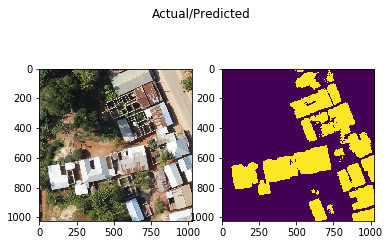

In [0]:
# Examine some outputs
idx = random.choice(range(len(test_df)))
print(idx)
img_id = test_df.id.values[idx]
pred_im = PImage.open(str(WORKDIR_PATH) + '/data/submission/'+str(img_id)+'.TIFF')
y_true = PImage.open(test_df.fn.values[idx])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Actual/Predicted')
ax1.imshow(np.array(y_true))
ax2.imshow(np.array(pred_im))

Create zip submission


In [0]:
# Create an appropriate submissions.zip file
!cd "/content/gdrive/My Drive/segmentation/data/submission" && zip -q -r "/content/gdrive/My Drive/segmentation/data/submission/submission.zip" *.TIFF # Add to archive